<a href="https://colab.research.google.com/github/JanHidranovich/machine_learning/blob/main/ae_with_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.reshape((60000, 28, 28)) / 255
x_test = x_test.reshape((10000, 28, 28)) / 255

y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)
hidden_dim = 8

11490434/11490434 [==============================] - 0s 0us/step


In [14]:
def normalize(args):
  global z_mean, z_log_var
  z_mean, z_log_var = args
  N = keras.backend.random_normal(shape=(1, hidden_dim), mean=0.0, stddev=1.0)
  return keras.backend.exp(z_log_var / 2) * N + z_mean

Input_image = keras.layers.Input(shape=(28, 28))
x = keras.layers.Flatten()(Input_image)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(.3)(keras.layers.BatchNormalization()(x))
x = keras.layers.Dense(128)(x)
x = keras.layers.Dense(hidden_dim)(x)

z_mean = keras.layers.Dense(hidden_dim)(x)
z_log_var = keras.layers.Dense(hidden_dim)(x)

h = keras.layers.Lambda(normalize, output_shape=(hidden_dim,))([z_mean, z_log_var])
Encoder = keras.Model(Input_image, h)
Encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 256)          200960      ['flatten_1[0][0]']              
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 256)         1024        ['dense_8[0][0]']                
 rmalization)                                                                               

In [ ]:
Input_hidden_vector = keras.layers.Input(shape=(hidden_dim,))
y = keras.layers.Dense(128)(Input_hidden_vector)
y = keras.layers.Dropout(.3)(keras.layers.BatchNormalization()(y))
y = keras.layers.Dense(256)(y)
y = keras.layers.Dense(784, activation='sigmoid')(y)
Output_image = keras.layers.Reshape((28,28, 1))(y)
Decoder = keras.Model(Input_hidden_vector, Output_image)
Decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_5 (Dense)             (None, 128)               1152      
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dense_7 (Dense)             (None, 784)               201488    
                                                           

In [ ]:
def vae_loss(x, decoded):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        x = keras.backend.reshape(x, shape=(50, 784))
        decoded = keras.backend.reshape(decoded, shape=(50, 784))
        loss = keras.backend.sum(keras.backend.square(x - decoded), axis=-1)
        kl_loss = -0.5 * keras.backend.sum(1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var), axis=-1)
        return (loss + kl_loss)

In [ ]:
AE = keras.Model(Input_image, Decoder(Encoder(Input_image)))

In [ ]:
AE.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 model (Functional)          (None, 8)                 236056    
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         236176    
                                                                 
Total params: 472,232
Trainable params: 471,464
Non-trainable params: 768
_________________________________________________________________


In [ ]:
AE.compile(optimizer="adam", loss=vae_loss);

In [ ]:
AE.fit(x_train, x_train, epochs=15, batch_size=50, shuffle=1)

Epoch 1/15
1200/1200 [==============================] - 17s 9ms/step - loss: 44.4995
Epoch 2/15
1200/1200 [==============================] - 8s 7ms/step - loss: 30.3223
Epoch 3/15
1200/1200 [==============================] - 9s 7ms/step - loss: 29.1033
Epoch 4/15
1200/1200 [==============================] - 8s 7ms/step - loss: 28.7497
Epoch 5/15
1200/1200 [==============================] - 9s 7ms/step - loss: 28.4950
Epoch 6/15
1200/1200 [==============================] - 9s 7ms/step - loss: 28.3570
Epoch 7/15
1200/1200 [==============================] - 8s 7ms/step - loss: 28.2361
Epoch 8/15
1200/1200 [==============================] - 8s 7ms/step - loss: 28.1477
Epoch 9/15
1200/1200 [==============================] - 9s 7ms/step - loss: 28.0722
Epoch 10/15
1200/1200 [==============================] - 9s 7ms/step - loss: 27.9576
Epoch 11/15
1200/1200 [==============================] - 8s 7ms/step - loss: 27.9373
Epoch 12/15
1200/1200 [==============================] - 9s 8ms/step - lo

200/200 [==============================] - 0s 1ms/step
(10000, 8)


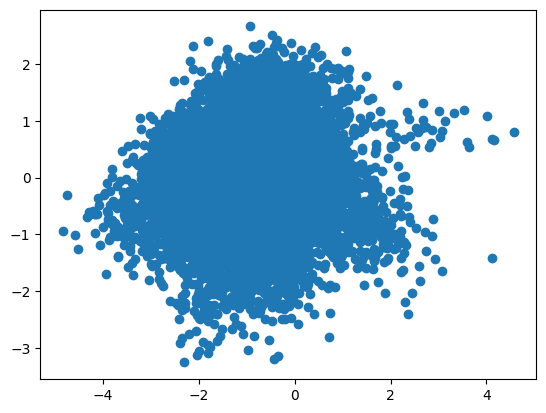

In [15]:
distribution = Encoder.predict(x_test, batch_size=50)
print(np.shape(distribution))
plt.scatter(distribution[:,0], distribution[:,1]);



In [16]:
predicted_image = Decoder.predict(distribution);

313/313 [==============================] - 0s 1ms/step
